## Sentiment Analysis for Mental Health

### 1 About Dataset:
This comprehensive dataset is a meticulously curated collection of mental health statuses tagged from various statements. The dataset amalgamates raw data from multiple sources, cleaned and compiled to create a robust resource for developing chatbots and performing sentiment analysis.

#### 1.2 Data Source: 
The dataset integrates information from the following Kaggle datasets:
- 3k Conversations Dataset for Chatbot
- Depression Reddit Cleaned
- Human Stress Prediction
- Predicting Anxiety in Mental Health Data
- Mental Health Dataset Bipolar
- Reddit Mental Health Data
- Students Anxiety and Depression Dataset
- Suicidal Mental Health Dataset
- Suicidal Tweet Detection Dataset

#### 1.3 Data Overview:
The dataset consists of statements tagged with one of the following seven mental health statuses:
- Normal
- Depression
- Suicidal
- Anxiety
- Stress
- Bi-Polar
- Personality Disordersorder

#### 1.4 Data Collection: 
The data is sourced from diverse platforms including social media posts, Reddit posts, Twitter Posts, and more. Each entry is tagged with a specific mental health status, making it an invaluable assest for:
- Developing intelligent mental health chatbots.
- Performing in-depth sentiment analysis.
- Research and studies related to mental health trends.

#### 1.5 Features:
- <b>unique_id</b>: A unique identifier for each entry.
- <b>Statement</b>: The textual data or post.
- <b>Mental Health Status</b>: The tagged mental health status of the statement.

### 2. Business Problem: 
#### 2.1 Problem Statement
-  Given a text statement, classify its sentiment into one of seven categories.
-  This task can be valuable for gaining insights into a user's emotional state in real-time, without requiring face-to-face interaction with a psychologist.

#### 2.2 Real World Objectives and Constraints
- The cost of misclassification can be extremely high in certain applications. For instance, if a user is expressing suicidal thoughts and a machine fails to accurately identify their sentiment, it could have severe consequences, potentially leading to tragic outcomes.
- Strict time latency: If a user posts suicidal thoughts on social media, the platform’s algorithm needs to detect the sentiment in real time to prevent potential harm before it occurs.

### 3 Mapping the real-world problem to ML problem
#### 3.1 Type of Machine Learning Problem
- It is a multi-class classification problem.
- <b> Multi-class classification: </b> Multi-class classification is a machine learning task where the goal is to predict which of several mutually exclusive classes an instance belongs to. For example, categorizing news articles into topics like politics, sports, or entertainment are multi-class classification problems.

#### 3.2 Performance Metric
- <b>Multi Class Log Loss</b>: Multi-class log loss measures how well predicted probabilities align with actual class labels, penalizing incorrect predictions more when the model is confident. Lower values indicate better performance.
- <b>Multi Class Confusion Matrix</b>: A multi-class confusion matrix shows the performance of a classification model by displaying the counts of true vs. predicted labels for each class. It helps identify which classes are often confused with each other.
- <b>Hamming Loss</b>: The Hamming loss is the fraction of labels that are incorrectly predicted.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc,roc_curve
from nltk.corpus import stopwords
from sklearn.multiclass import OneVsRestClassifier
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from nltk.corpus import wordnet #to ensure accurate lemmatization

In [2]:
df = pd.read_csv("Combined Data.csv")

#### 3.3 Example Data Point

In [3]:
df.head(3)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety


#### 3.4 Data Shape

In [4]:
df.shape

(53043, 3)

- We have 53,043 rows of data in our dataset.

#### 3.5 Train and Test Construction
- We divided the dataset into two parts: 70% for training the model and 30% for evaluating its performance. This was possible because we had enough data to create meaningful training and testing sets.

### 4. Exploratory Data Analysis
#### 4.1 Data Cleaning

##### 4.1.1 Remove Null Values
- We remove null values from our data to ensure the accuracy and reliability of our analysis and model predictions.

In [5]:
df.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

<b> Observations: </b>
- We have 362 missing values in the "statement" column.

In [6]:
df.dropna(inplace=True)

##### 4.1.2 Remove Duplicate Columns
- We remove duplicates to prevent the model from being biased.
- We are removing duplicate rows based on the 'statement' and 'status' columns, keeping only the first occurrence of each unique combination.

In [7]:
df.drop_duplicates(subset={'statement','status'},keep='first',inplace=True)

In [8]:
df.shape

(51093, 3)

- We have 51093 rows of data after removing duplicates and missing rows.
- We removed 1,950 rows as part of our data cleaning process.

- Lets visualize them 😉


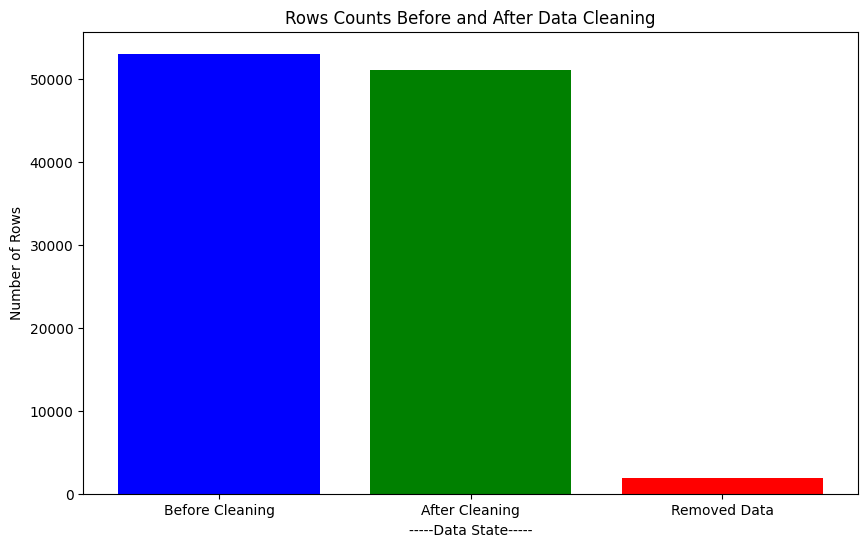

In [9]:
categories = ['Before Cleaning','After Cleaning','Removed Data']
counts = [53043,51093,1950]
plt.figure(figsize=(10,6))
plt.bar(categories,counts,color=['blue','green','red'])
plt.title("Rows Counts Before and After Data Cleaning")
plt.xlabel("-----Data State-----")
plt.ylabel("Number of Rows")
plt.show()

##### 4.1.3 Removing HTML Tags
- We encountered decoding problems while using BeautifulSoup, so we are avoiding these issues by converting our data to string format.

In [10]:
df['statement']=df['statement'].apply(lambda x: str(x))

In [11]:
df['clean_text']=df['statement'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

C:\Users\hatyy\AppData\Local\Temp\ipykernel_13508\4053108552.py:1: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['clean_text']=df['statement'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())


##### 4.1.4 Converting text to lowercase format
<b> Question for you: </b> <br>
<br>  Why do we convert text to lowercase format?🤔 <br>
<br> <b> Answer for you: </b> <br>- Converting text to lowercase standardizes it, making it easier for NLP algorithms to process and understand. This helps reduce the number of unique features and ensures consistent treatment of different variations of the same word.

  > https://www.youtube.com/watch?v=Bs3CyJ9huh8


In [12]:
df['clean_text']=df['clean_text'].str.lower()

##### 4.1.5 Decontraction
- Decontraction is the process of expanding contracted words into their full forms. For example, "can't" becomes "cannot" and "don't" becomes "do not".

In [13]:
def decontracted (phrase):
    phrase = re.sub(r"won\'t", "will not",phrase)
    phrase = re.sub(r"can\'t", "can not",phrase)
    phrase = re.sub(r"didn\'t", "did not",phrase)
    phrase = re.sub(r"haven\'t", "have not",phrase)
    phrase = re.sub(r"wouldn\'t", "would not", phrase)
    phrase = re.sub(r"hadn\'t", "had not",phrase)
    phrase = re.sub(r"don\'t", "do not",phrase)
    phrase = re.sub(r"wasn\'t","was not",phrase)
    phrase = re.sub(r"isn\'t","is not",phrase)

    phrase = re.sub(r"n\'t'", " not",phrase)
    phrase = re.sub(r"\'re", " are" ,phrase)
    phrase = re.sub(r"\'s", " is",phrase)
    phrase = re.sub(r"\'ve", " have",phrase)
    phrase = re.sub(r"\'d", " had",phrase)
    phrase = re.sub(r"\'m", " am",phrase)
    phrase = re.sub(r"\'t"," not",phrase)
    return phrase

- Example of a text before applying decontraction<b>:</b>



In [14]:
df['clean_text'].loc[4]

"i'm restless and restless, it's been a month now, boy. what do you mean?"

In [15]:
df['clean_text']=df['clean_text'].apply(decontracted)

- Example of a text after applying decontraction<b>:</b>

In [16]:
df['clean_text'].loc[4]

'i am restless and restless, it is been a month now, boy. what do you mean?'

##### 4.1.6 Remove Noise
- HTML links, special symbols, and unwanted spaces can be considered noise in text data, as they can negatively impact the performance of machine learning models.
- These elements can introduce irrelevant information or inconsistencies that can hinder the model's ability to learn meaningful patterns.
- Consequently, we are removing HTML links, special symbols, and unwanted spaces.

In [17]:
def rem_noise(phrase):
    phrase = re.sub(r'[^a-zA-Z\s]',' ',phrase)
    phrase = re.sub(r'http\S+',"",phrase)
    phrase = re.sub(r"\s{2,}", " ", phrase) #remove unwanted space
    return phrase

- Example of a text before removing noise: 

In [18]:
df['clean_text'].loc[30104]

'most diagnoses, except those relating to the endangerment of children, are welcome. this is a first person group, so you need to be the person with a disorder to participate. to join visit our site [https://thehaven.support](https://thehaven.support/) or check out our instagram:  we believe we are stronger together, which is why peer support is so helpful and important. care when you need it; care for others when you can. \\-zen'

In [19]:
df['clean_text']=df['clean_text'].apply(rem_noise)

- Example of a text after removing noise: 

In [20]:
df['clean_text'].loc[30104]

'most diagnoses except those relating to the endangerment of children are welcome this is a first person group so you need to be the person with a disorder to participate to join visit our site thehaven support thehaven support or check out our instagram we believe we are stronger together which is why peer support is so helpful and important care when you need it care for others when you can zen'

#### 4.2 Distribution 
- Let's examine the class distribution in our dataset:

In [21]:
df['status'].value_counts()

status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

- Let's create a visual representation of the data. 😎


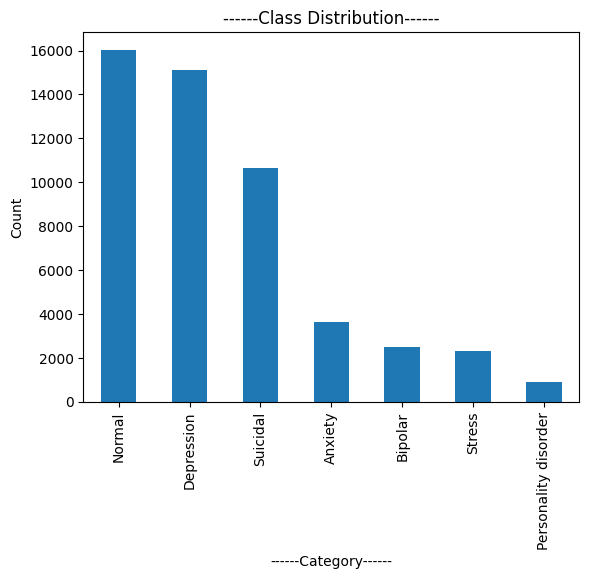

In [22]:
value_counts=df['status'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel("------Category------")
plt.ylabel("Count")
plt.title("------Class Distribution------")
plt.show()

<b> Observations: </b>
- Most individuals do not have any significant mental health issues.
- The second most common condition is depression, affecting 15,094 individuals.
- A significant number of individuals (10,644) are struggling with suicidal thoughts.
- In <b> conclusion</b>, the dataset exhibits class imbalance.



### 5. Text Preprocessing
#### 5.1 Tokenization
- Tokenization is the process of breaking down text into smaller units called tokens.
- We are using Word Tokenization.
- Example of word tokenization:
  > "This is a sentence" -> ["This", "is", "a", "sentence"]

In [23]:
df['clean_text']=df['clean_text'].apply(word_tokenize)

- Let's observe the results of breaking text into tokens. 🥸

In [24]:
df.head(1)

,Unnamed: 0,statement,status,clean_text
0,0,oh my gosh,Anxiety,"[oh, my, gosh]"


#### 5.2 Stop-Words Removal
- Despite the potential benefits of removing stop words, we found that doing so in our specific case led to a degradation in sentiment analysis performance. As a result, we decided to retain stop words to preserve the nuanced meaning of the text.

#### 5.3 Lemmatization
- Lemmatization reduces words to their dictionary form (lemma). For example, "better" becomes "good", "running" becomes "run". It considers word context to produce accurate results.


- Let's visualize the tokenized text before applying lemmatization.

In [25]:
df['clean_text'].loc[511]

['seriously',
 'i',
 'have',
 'never',
 'been',
 'worried',
 'about',
 'getting',
 'older',
 'but',
 'how',
 'come',
 'i',
 'am',
 'this',
 'time',
 'i',
 'am',
 'really',
 'worried',
 'it',
 'feels',
 'like',
 'my',
 'time',
 'is',
 'running',
 'out']

In [26]:
lemmatizer = WordNetLemmatizer()
df['clean_text']=df['clean_text'].apply(lambda x: [lemmatizer.lemmatize(word, wordnet.VERB) for word in x])

- Let's visualize the tokenized text after applying lemmatization.

In [27]:
df['clean_text'].loc[511]

['seriously',
 'i',
 'have',
 'never',
 'be',
 'worry',
 'about',
 'get',
 'older',
 'but',
 'how',
 'come',
 'i',
 'be',
 'this',
 'time',
 'i',
 'be',
 'really',
 'worry',
 'it',
 'feel',
 'like',
 'my',
 'time',
 'be',
 'run',
 'out']

#### 5.4 Joining
- Reconstruct the processed text by joining the tokenized words. This step involves combining the individual words back into a coherent sentence.

In [28]:
df['clean_text']=df['clean_text'].apply(lambda x: ' '.join(x))

In [29]:
df.head(1)

,Unnamed: 0,statement,status,clean_text
0,0,oh my gosh,Anxiety,oh my gosh


In [30]:
df['clean_text'].loc[511]

'seriously i have never be worry about get older but how come i be this time i be really worry it feel like my time be run out'

#### 5.7 Conversion
- Convert the categorical target variable to numerical values.

> Prior to converting the target variable, let's save the preprocessed data to a new CSV file named <b> 'clean.csv'</b>.

In [31]:
df.to_csv('clean.csv',index=False)

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

- Let's load our preprocessed data from the 'clean.csv' file.

In [32]:
df = pd.read_csv('clean.csv')

In [33]:
df.isna().sum()

Unnamed: 0    0
statement     0
status        0
clean_text    6
dtype: int64

- There were six missing values in the 'clean_text' feature of our preprocessed data.
- We are removing the missing values.

In [34]:
df.dropna(inplace=True)

- Let's perform our conversion task. 🤩


In [35]:
def num_fea(phrase):
    mapping = {
        'Normal': 0,
        'Depression': 1,
        'Suicidal': 2,
        'Anxiety': 3,
        'Bipolar': 4,
        'Stress': 5
    }
    return mapping.get(phrase, 6)

In [36]:
df['status']=df['status'].apply(num_fea)

In [37]:
df.head(1)

,Unnamed: 0,statement,status,clean_text
0,0,oh my gosh,3,oh my gosh


### 6 Machine Learning Model
#### 6.1 Train-Test Split
- Let's split our data into a 70:30 training-testing ratio.


In [38]:
y_true=df['status']
y_true

0        3
1        3
2        3
3        3
4        3
        ..
51088    3
51089    3
51090    3
51091    3
51092    3
Name: status, Length: 51087, dtype: int64

In [39]:
X_train,X_test,y_train,y_test=train_test_split(df,y_true,stratify=y_true,test_size=0.3,random_state=44)

#### 6.2 Distribution of Target Variable
##### 6.2.1 Distribution of the target variable in the training data

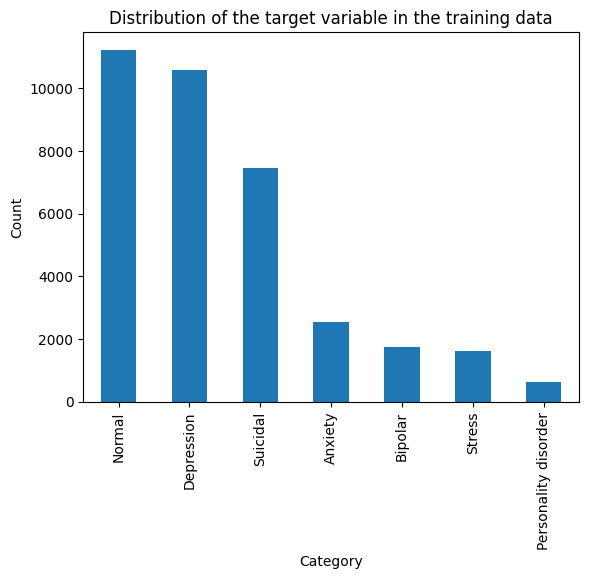

In [40]:
value_counts = X_train['status'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of the target variable in the training data")
plt.xticks([0,1,2,3,4,5,6],['Normal','Depression','Suicidal','Anxiety','Bipolar','Stress','Personality disorder'])
plt.show()

- If the plots are difficult to interpret, here are the exact numerical values 🫣

In [41]:
X_train['status'].value_counts()

status
0    11225
1    10566
2     7449
3     2536
4     1751
5     1607
6      626
Name: count, dtype: int64

##### 6.2.3 Distribution of the target variable in the testing data

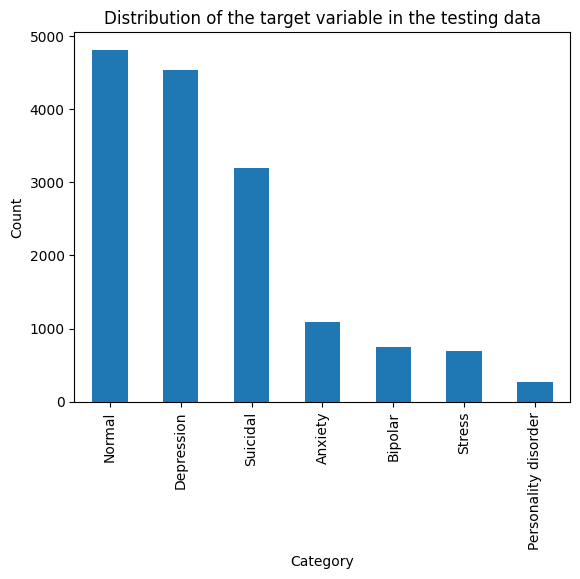

In [42]:
value_counts = X_test['status'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of the target variable in the testing data")
plt.xticks([0,1,2,3,4,5,6],['Normal','Depression','Suicidal','Anxiety','Bipolar','Stress','Personality disorder'])
plt.show()

In [43]:
X_test['status'].value_counts()

status
0    4811
1    4528
2    3193
3    1087
4     750
5     689
6     269
Name: count, dtype: int64

In [44]:
print("Total number of samples in the training data: {}".format(X_train.shape[0]))
print('**'*26)
print("Total number of samples in the test data: {}".format(X_test.shape[0]))

Total number of samples in the training data: 35760
****************************************************
Total number of samples in the training data: 15327


#### 6.3 Feature Elimination 
- Feature elimination, is a technique used in machine learning to remove irrelevant or redundant features from a dataset.
- By removing the 'status' column from both the training and testing data, we are preventing potential data leakage, ensuring that the model is not exposed to information it shouldn't have access to during training.

In [45]:
X_train.head()

,Unnamed: 0,statement,status,clean_text
27113,27215,it feels like life and everyone i know is pass...,1,it feel like life and everyone i know be pass ...
31618,31805,do you need a pen?,0,do you need a pen
16013,16105,Then maybe they would give a shit. Maybe they ...,2,then maybe they would give a shit maybe they w...
20786,20882,I am tired of existing. I quit. I am handing i...,2,i be tire of exist i quit i be hand in my week...
39105,39467,so i recently started my first customer servic...,1,so i recently start my first customer service ...


In [46]:
X_train.drop(['Unnamed: 0','statement','status'],axis=1,inplace=True)

In [47]:
X_train

,clean_text
27113,it feel like life and everyone i know be pass ...
31618,do you need a pen
16013,then maybe they would give a shit maybe they w...
20786,i be tire of exist i quit i be hand in my week...
39105,so i recently start my first customer service ...
...,...
17273,just wake up after hours of sleep and i be sti...
17463,you know that feel of go insane it be a hard f...
47630,i hate this phrase people always jump to say s...
30941,what do you want me to do


In [48]:
X_test.drop(['Unnamed: 0','statement','status'],axis=1,inplace=True)

#### 6.4 Text Featurization
##### 6.4.1 TF-IDF
- We are converting the text in the 'clean_text' column to unigram TF-IDF vectors.
  > Transforming the training data text into TF-IDF vectors using default parameters.

In [49]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text'])
X_train_tfidf.get_shape()

(35760, 39716)

> Transforming the testing data text into TF-IDF vectors using default parameters.

In [50]:
X_test_tfidf = vectorizer.transform(X_test['clean_text'])
X_test_tfidf.get_shape()

(15327, 39716)

#### 6.5 Confusion Matrix
- Here's a code snippet to plot a confusion matrix, precision, and recall matrix.

In [51]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
   
    
    labels =['Normal','Depression','Suicidal','Anxiety','Bipolar','Stress','Personality disorder']
    # representing A in heatmap format
    print('-'*30,"Confusion Matrix",'-'*30)
    plt.figure(figsize=(20,5))
    cmap=sns.light_palette("blue")
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('----Predicted Class----')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*30,"Precision Matrix",'-'*30)
    plt.figure(figsize=(20,5))
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('----Predicted Class----')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*30,"Recall Matrix",'-'*30)
    plt.figure(figsize=(20,5))
    sns.heatmap(A, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('----Predicted Class----')
    plt.ylabel('Original Class')
    plt.show()

#### 6.6 Random Model
- A random model predicts class labels randomly, regardless of the input data. It's often used as a baseline to evaluate the performance of more complex models.

Log Loss on test data using random model:  2.225326056690311
------------------------------ Confusion Matrix ------------------------------


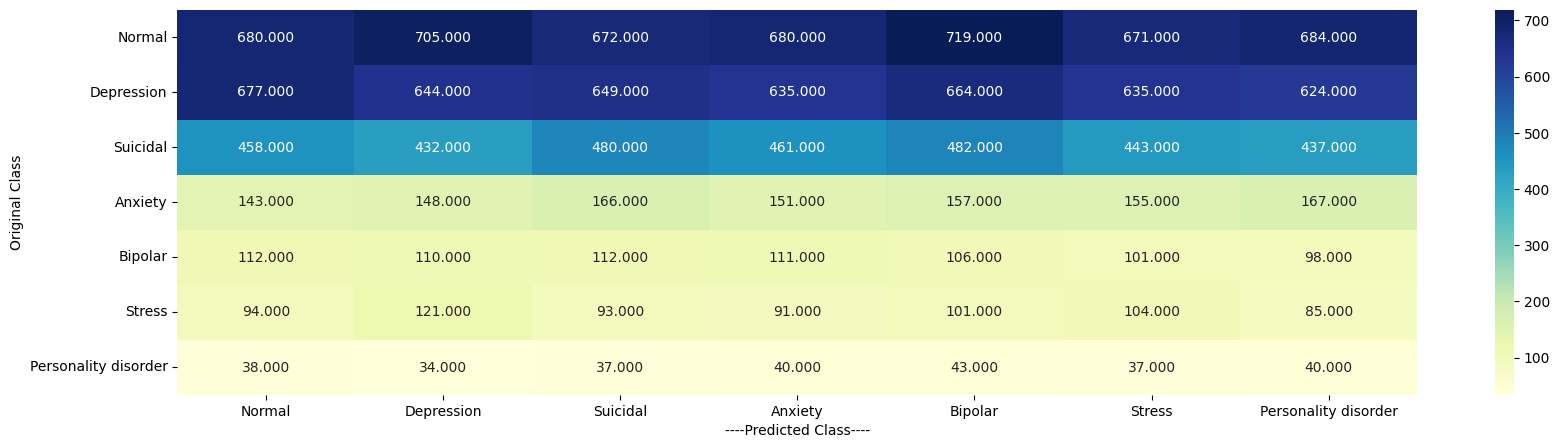

------------------------------ Precision Matrix ------------------------------


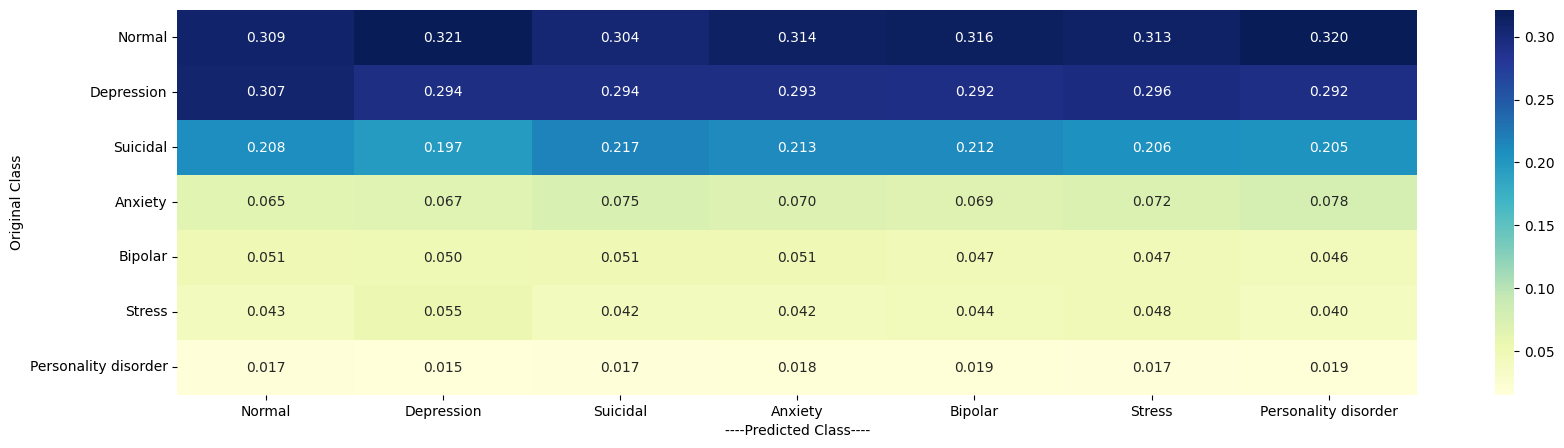

------------------------------ Recall Matrix ------------------------------


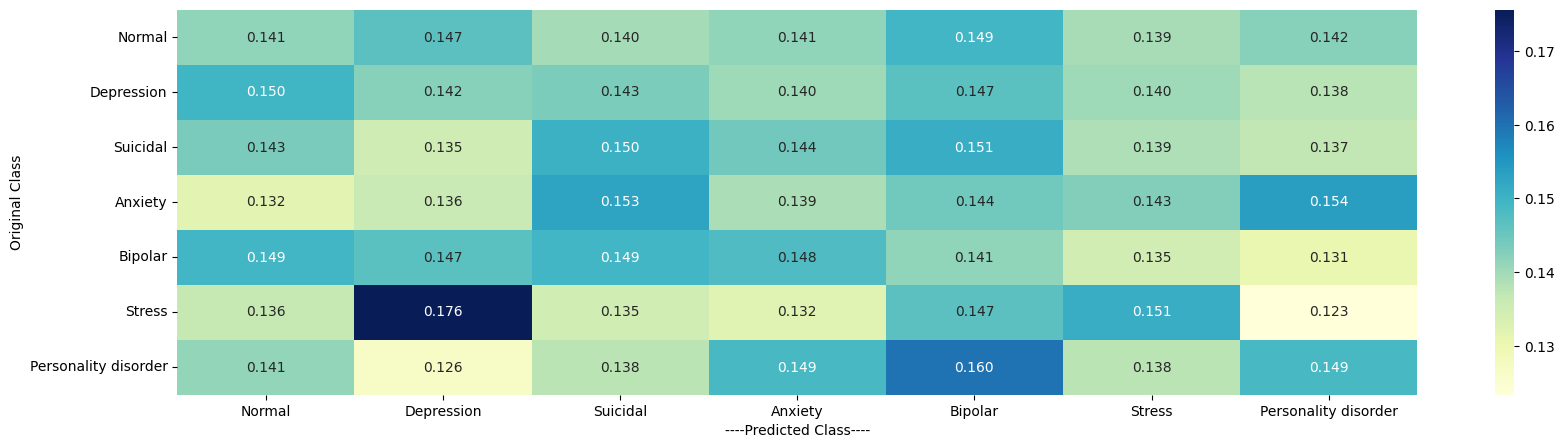

In [52]:
train_len = len(y_train)
test_len = len(y_test)
predicted_y = np.zeros((test_len,7))
for i in range(test_len):
    rand_probs = np.random.rand(1,7)
    predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on test data using random model: ",log_loss(y_test,predicted_y))

predicted_y = np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y)

#### 6.7 SGD Classifier with Logistic Regression Loss Function
##### 6.7.1 Without class balance

For values of alpha =  1e-07 The log loss is: 0.8141795966027382
For values of alpha =  1e-06 The log loss is: 0.7229674122378026
For values of alpha =  1e-05 The log loss is: 0.6681940032117503
For values of alpha =  0.0001 The log loss is: 0.7162528502148661
For values of alpha =  0.001 The log loss is: 0.8920179241382613
For values of alpha =  0.01 The log loss is: 1.16184945644992
For values of alpha =  0.1 The log loss is: 1.3321149085959407
For values of alpha =  1 The log loss is: 1.3193953426165639
For values of alpha =  10 The log loss is: 1.3183176377839583
For values of alpha =  100 The log loss is: 1.3181999786892526


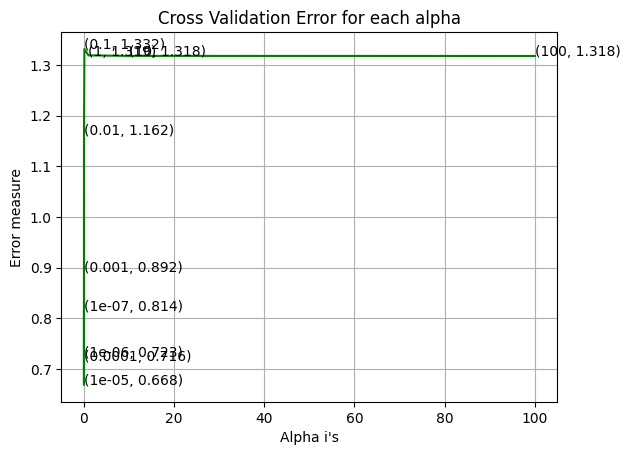

For values of best alpha =  1e-05 The train log loss is: 0.47540621317250653
For values of best alpha =  1e-05 The test log loss is: 0.6681940032117503
Total number of data points : 15327
------------------------------ Confusion Matrix ------------------------------


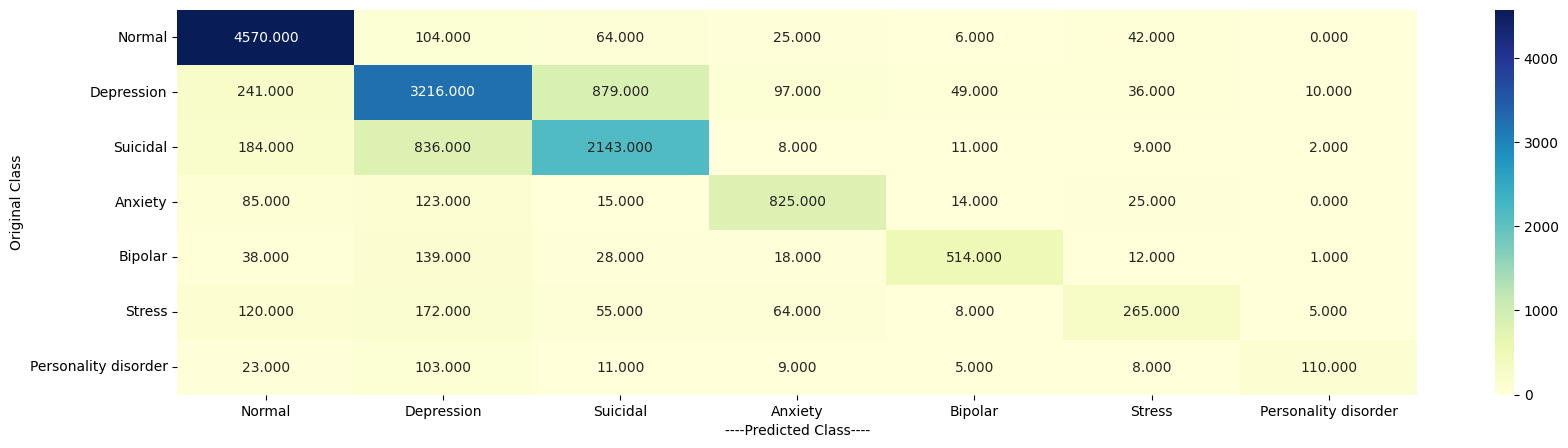

------------------------------ Precision Matrix ------------------------------


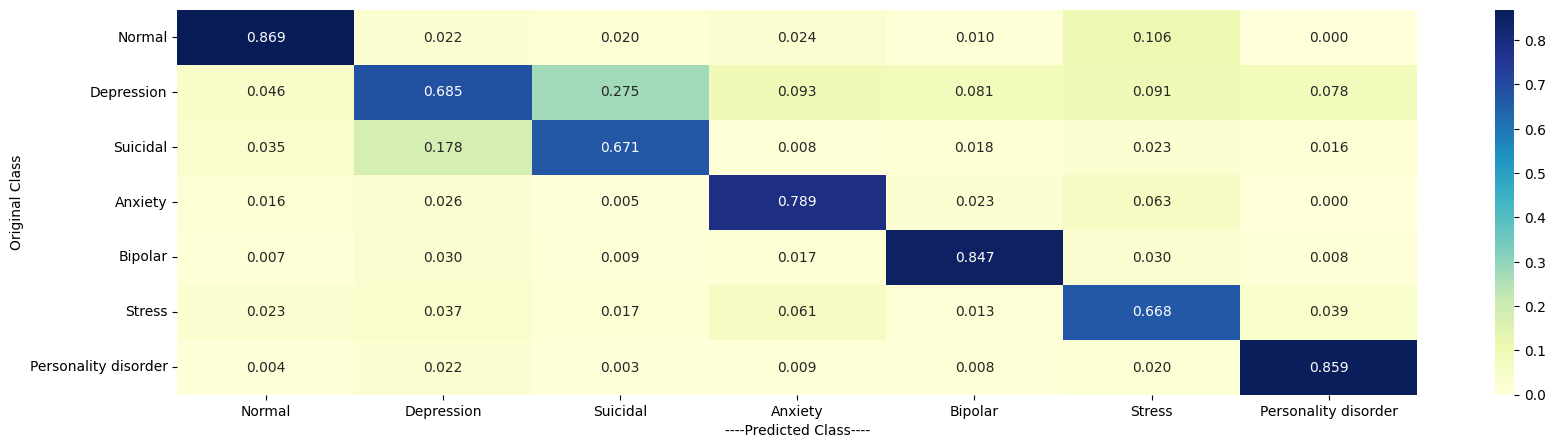

------------------------------ Recall Matrix ------------------------------


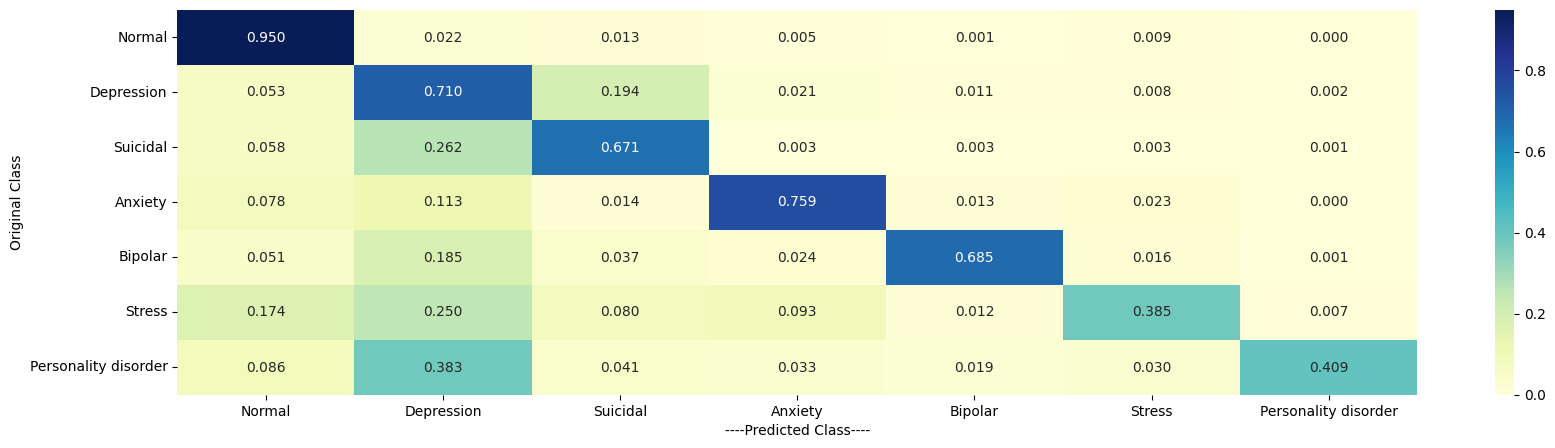

In [53]:
alpha = [10 ** x for x in range(-7, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss',random_state=44,max_iter=1000)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss',random_state=44,max_iter=1000)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### 6.7.2 With Class Balance

For values of alpha =  1e-07 The log loss is: 0.8045600287940321
For values of alpha =  1e-06 The log loss is: 0.7270524664067255
For values of alpha =  1e-05 The log loss is: 0.6742093409462553
For values of alpha =  0.0001 The log loss is: 0.7183977238940755
For values of alpha =  0.001 The log loss is: 0.8568008641614132
For values of alpha =  0.01 The log loss is: 1.2455906641037962
For values of alpha =  0.1 The log loss is: 1.3180623942680791
For values of alpha =  1 The log loss is: 1.313803723933943
For values of alpha =  10 The log loss is: 1.3133724669558997
For values of alpha =  100 The log loss is: 1.3133252822361625


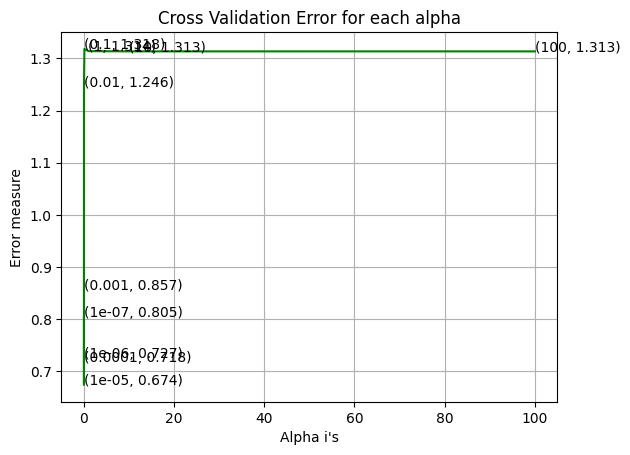

For values of best alpha =  1e-05 The train log loss is: 0.4769180836627787
For values of best alpha =  1e-05 The test log loss is: 0.6742093409462553
Total number of data points : 15327
------------------------------ Confusion Matrix ------------------------------


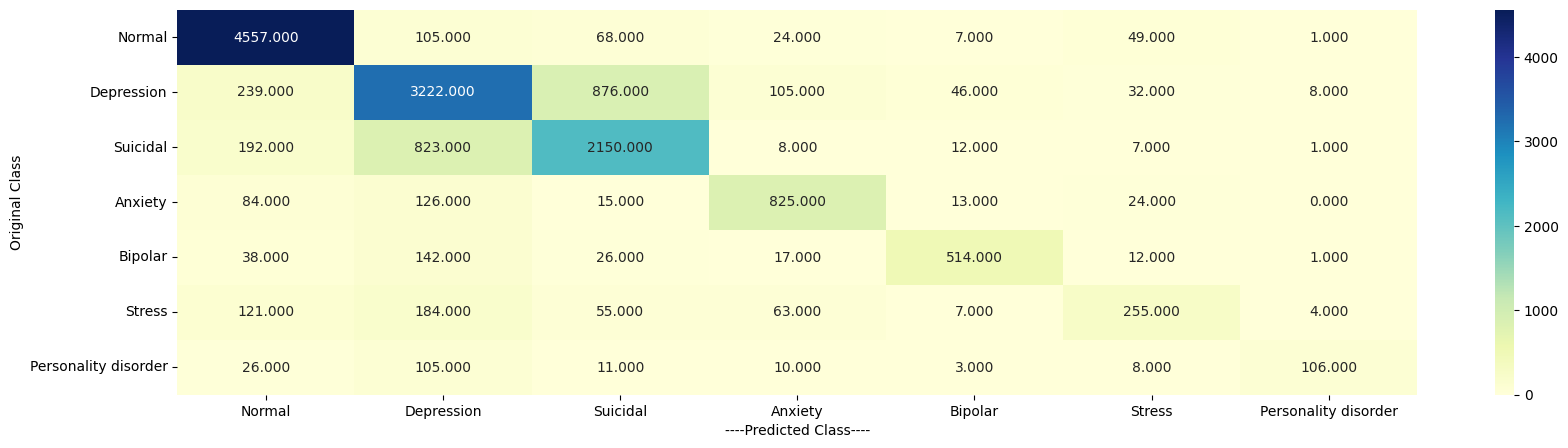

------------------------------ Precision Matrix ------------------------------


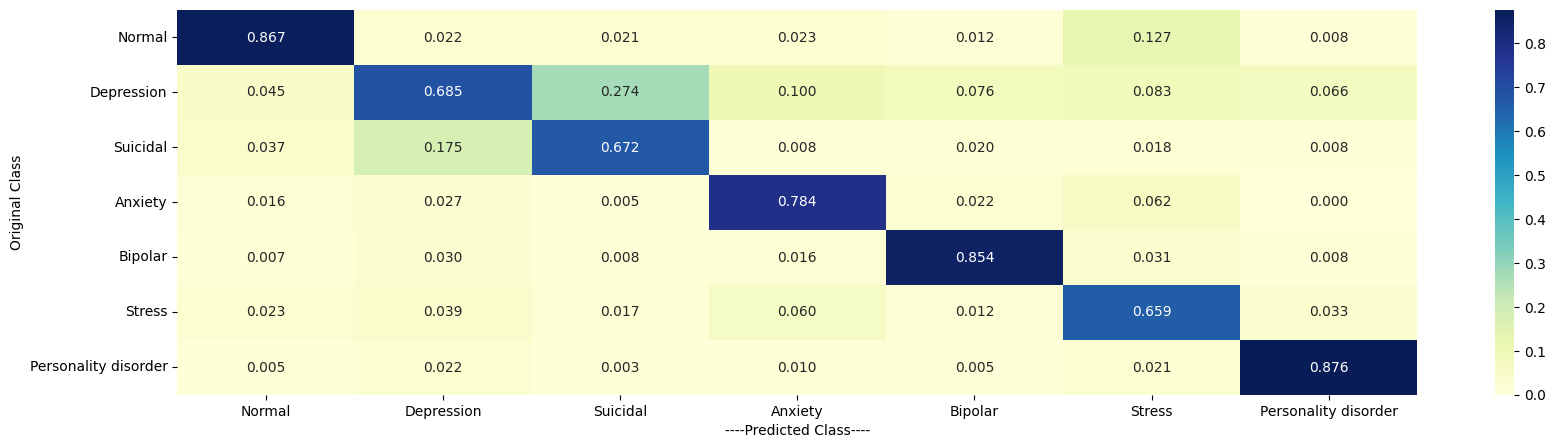

------------------------------ Recall Matrix ------------------------------


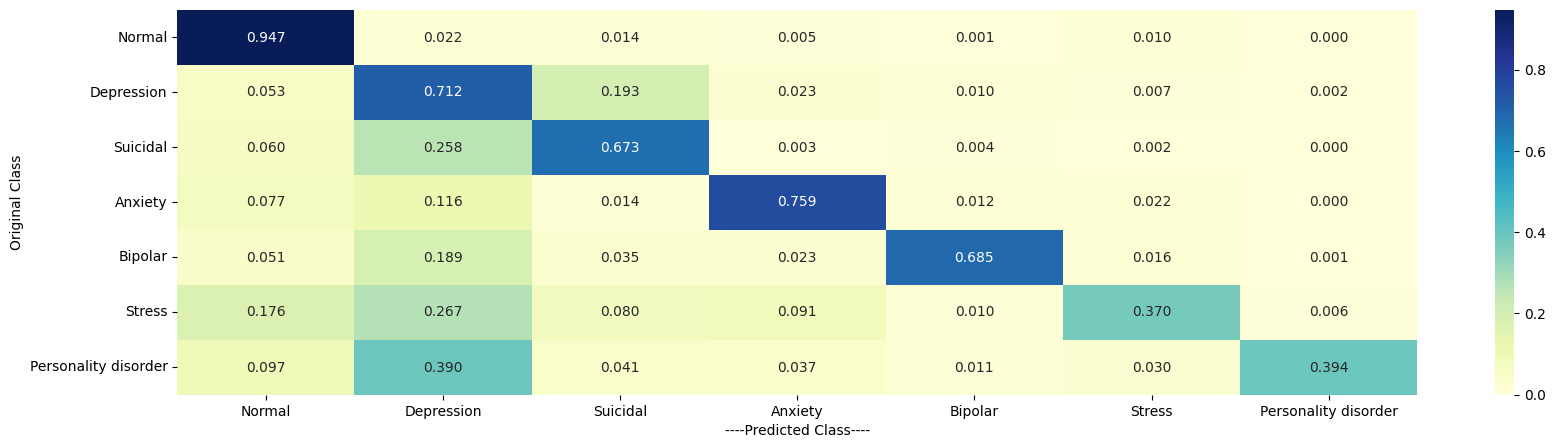

In [54]:
#with class balance
alpha = [10 ** x for x in range(-7, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='log_loss',random_state=44,max_iter=1000)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='log_loss',random_state=44,max_iter=1000)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### 6.8 Logistic Regression
- Logistic regression with balanced class weights using the one-vs-rest strategy.

Hamming Loss:  0.24538396294121484
------------------------------ Confusion Matrix ------------------------------


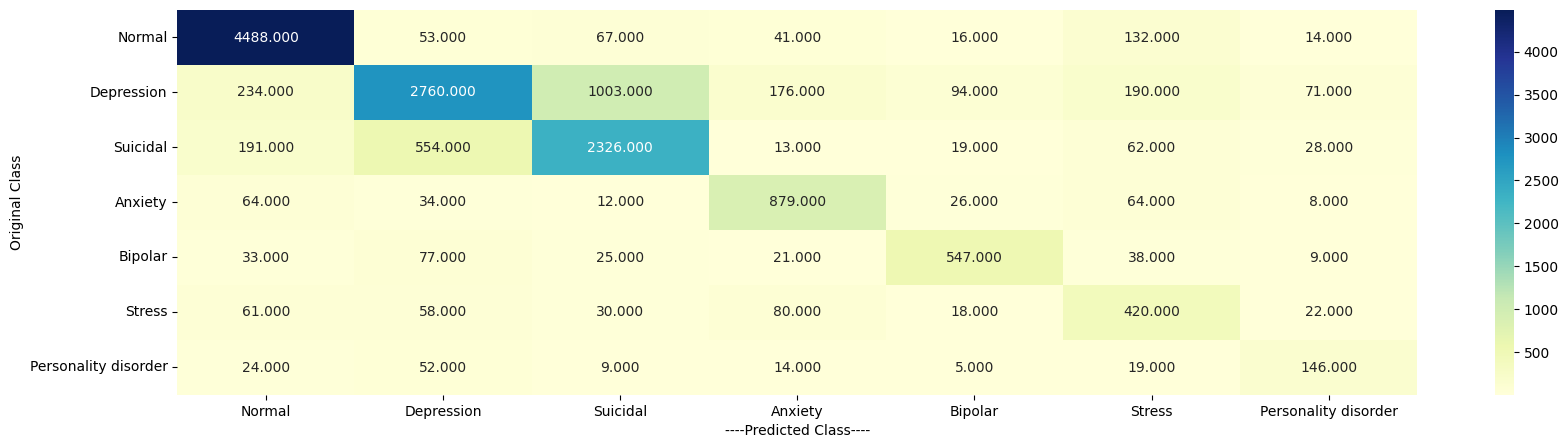

------------------------------ Precision Matrix ------------------------------


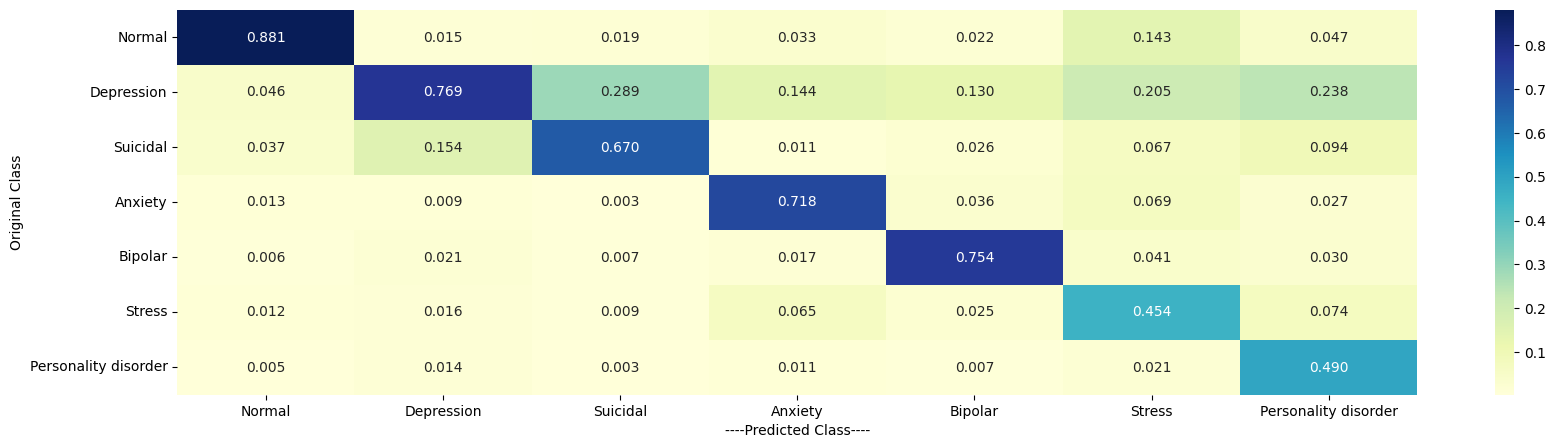

------------------------------ Recall Matrix ------------------------------


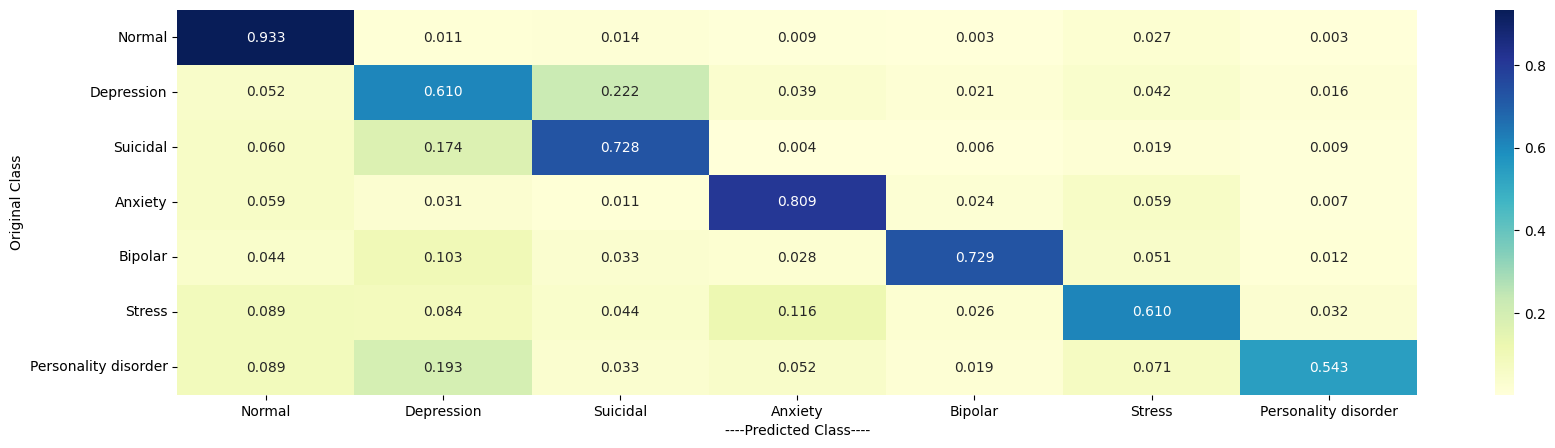

In [55]:
classifier = OneVsRestClassifier(LogisticRegression(class_weight='balanced',penalty='l2',random_state=44),n_jobs=-1)
classifier.fit(X_train_tfidf,y_train)
predictions = classifier.predict(X_test_tfidf)
print("Hamming Loss: ",metrics.hamming_loss(y_test,predictions))
plot_confusion_matrix(y_test, predictions)


- <b> Observations: </b>
- The recall rate for the 'Depression' class is 61%. This means that 61% of the actual instances of depression were correctly identified by the model. Additionally, 22% of depression cases were incorrectly classified as 'Suicidal'.
- The recall rate for the 'Suicidal' class is 72.8%. This means that 72.8% of the actual instances of suicidal sentiment were correctly identified by the model. Additionally, 17.4% of suicidal cases were incorrectly classified as 'Depression'.
  > All models exhibit high recall rates for the 'Normal' class.
  

- <b>Conclusions: </b>
- Since identifying suicidal sentiment is a critical task, we prioritized achieving a high recall rate for this class. Logistic regression with balanced class weights using the one-vs-rest strategy proved to be an effective model for this purpose.

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------


> Let's analyze the reasons for the high confusion between the 'Depression' and 'Suicidal' classes. 🤔


- Let's reload the preprocessed data and eliminate any missing values.

In [56]:
df = pd.read_csv('clean.csv')

In [57]:
df.isna().sum()

Unnamed: 0    0
statement     0
status        0
clean_text    6
dtype: int64

In [58]:
df.dropna(inplace=True)

- Given that stop words do not significantly contribute to the confusion between the 'Depression' and 'Suicidal' classes, we are removing them from the analysis.

In [59]:
stopwords = set(stopwords.words('english'))

In [60]:
df['no_stop']=df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [61]:
df.head()

,Unnamed: 0,statement,status,clean_text,no_stop
0,0,oh my gosh,Anxiety,oh my gosh,oh gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleep confuse mind restless heart all ...,trouble sleep confuse mind restless heart tune
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...
3,3,I've shifted my focus to something else but I'...,Anxiety,i have shift my focus to something else but i ...,shift focus something else still worry
4,4,"I'm restless and restless, it's been a month n...",Anxiety,i be restless and restless it be be a month no...,restless restless month boy mean


- We are extracting the text data from the 'no_stop' column for the 'Depression' and 'Suicidal' classes, converting it into lists and storing it in class1_text and class2_text respectively.

In [62]:
class1_text = df[df['status'] == 'Depression']['no_stop'].tolist()
class2_text = df[df['status'] == 'Suicidal']['no_stop'].tolist()

- Let's examine the first element of the class1_text list.


In [63]:
print(class1_text[0])

recently go breakup say still want friends say try talk things always hurt want lose feel pain stop hurt much even cry want hurt say want never speak know together always hurt know still love wish never meet would much less painful lose feel


- Transforming the list into a set.
- A set contains unique elements, meaning it only includes one instance of each word or value.

In [64]:
class1_set = set(' '.join(class1_text).split())
class2_set = set(' '.join(class2_text).split())

- Let's determine the number of unique words in each set.

In [65]:
print("Number of unique words in class1_set: (Depression) ",len(class1_set))
print('**'*28)
print("Number of unique words in class2_set: (Suicidal) ",len(class2_set))

Number of unique words in class1_set: (Depression)  25825
********************************************************
Number of unique words in class2_set: (Suicidal)  19575


In [66]:
intersection = class1_set.intersection(class2_set)

In [67]:
print("Count of the shared words between 'Depression' and 'Suicidal' classes: "  ,len(intersection))

Count of the shared words between 'Depression' and 'Suicidal' classes:  12002


In [68]:
percentage = (len(intersection)/len(class1_set))*100

In [69]:
print("Of the shared words between the 'Depression' and 'Suicidal' classes, {}% contribute to the overall text associated with the 'Depression' class".format(round(percentage,2)))

Of the shared words between the 'Depression' and 'Suicidal' classes, 46.47% contribute to the overall text associated with the 'Depression' class


In [70]:
percentage1 = (len(intersection)/len(class2_set))*100

In [71]:
print("Of the shared words between the 'Depression' and 'Suicidal' classes, {}% contribute to the overall text associated with the 'Suicidal' class.".format(round(percentage1,2)))

Of the shared words between the 'Depression' and 'Suicidal' classes, 61.31% contribute to the overall text associated with the 'Suicidal' class.


- <b> Observations: </b>
- Of the unique words in the 'Suicidal' class, 38.69% are not present in the 'Depression' class.
- Of the unique words in the 'Depression' class, 53.53% are not present in the 'Suicidal' class.